# Pipeline for Processing GeneLab Amplicon Sequencing Data

> **The 3 Amplicon Seq Jupyter Notebook (JNs) are designed for processing samples derived from the feces of mice that were either flown in space aboard the International Space Station (ISS) (spaceflight, FLT, animals) or kept in an environmental simulator on Earth to serve as ground controls (GC, animals) during NASA's Rodent Research - 6 mission. More information about the samples analyzed here can be found in the [Open Science Data Repository (OSDR)](https://osdr.nasa.gov/bio/repo/) under [OSD-249](https://osdr.nasa.gov/bio/repo/data/studies/OSD-249). We will be processing these samples using the [GeneLab Amplicon Sequencing Data Processing Pipeline](https://github.com/nasa/GeneLab_Data_Processing/blob/master/Amplicon/Illumina/Pipeline_GL-DPPD-7104_Versions/GL-DPPD-7104-A.md) for Illumina sequence data.**  

<br>

---

## Amplicon Pipeline Overview
> This JN will cover the pipeline steps outlined in red. 
> Note that after assessing raw data quality, we will move to the [Amplicon Processing JN](05-amplicon-processing.ipynb) for the Primer Removal and Quality Filtering/Trimming steps, then return to this JN to assess the filtered and trimmed data quality. 

<br>

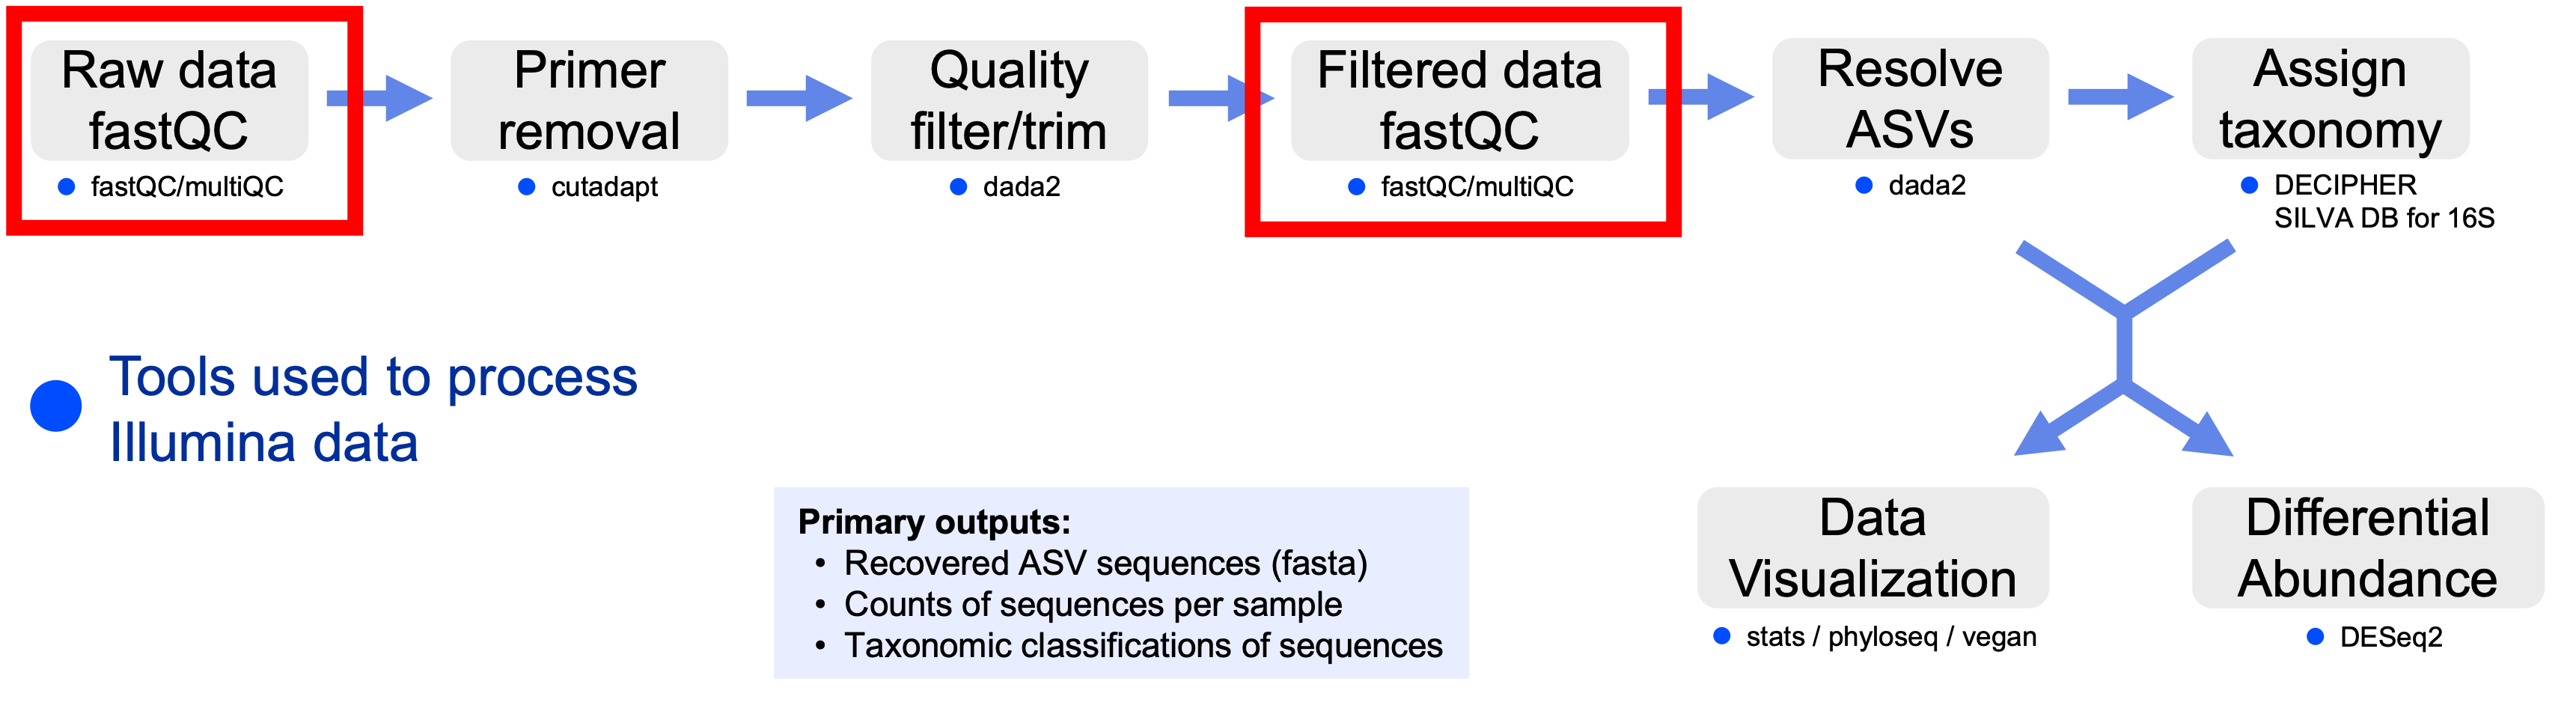

<br>

<hr style="height:0px; visibility:hidden;" />

<h1><center>4. Setup and QC</center></h1>

<div class="alert alert-block alert-success">
Here we are going to setup a directory structure to store the output data we'll generate, and we are going to use a popular tool for assessing the quality of our reads. Both of these are most easily done at a Unix-like command line, so this notebook uses a "Bash" kernel, a common language used in a Unix-like environment. 
</div>

---

This is notebook 4 of 6 of <a href="00-overview.ipynb">GL4U's Amplicon Seq Bootcamp</a>. It is expected that the previous notebooks have been completed already.

---

[**Previous:** 3. R intro](03-R-intro.ipynb)
<br>

<div style="text-align: right"><a href="05-amplicon-processing.ipynb"><b>Next:</b> 5. Amplicon processing</a></div>

---
---

# Table of Contents

* [1. Setting up](#setup)
* [2. Quality assessment of raw reads](#rawqa) 
* [3. Quality assessment of filtered reads](#filteredqa)

<br>

---
---

<a class="anchor" id="setup"></a>

## 1. Setting up
First we are going to create a new directory within our "home" location for us to work in using the `mkdir` command, and then we'll use the `cd` command to change into the directory we made:

In [1]:
mkdir -p ~/GL4U-amplicon-tutorial
cd ~/GL4U-amplicon-tutorial

<div class="alert alert-block alert-info">
<b>NOTE</b><br>
The <code>-p</code> option included above with the <code>mkdir</code> command is added so that if we need to re-run that code block for any reason, it won't throw an error when we try to create a directory that exists already (which is the default behavior of <code>mkdir</code>).
</div>

Now let's check where we are and if there are any files/directories present:

In [7]:
pwd
ls

/Users/mdlee4/GL4U-amplicon-tutorial
old


Next we are going to download the raw data files that we will start with, then unpack them with these commands:

In [21]:
curl -L -o raw-reads.tar.gz https://figshare.com/ndownloader/files/39537235
tar -x -f raw-reads.tar.gz
rm raw-reads.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 18.0M  100 18.0M    0     0  2228k      0  0:00:08  0:00:08 --:--:-- 3433k


<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `curl`   - the primary command we're using, which can download files from the internet
    - `-L`   - this tells `curl` to follow any redirecting links if they exist
    - `-o`   - the output name we want to give to the file we're downloading
    - last to `curl` is a positional arugment that is the address of the file we want to download

- `tar` - the primary command we're using, a "tar" is a type of archive that can hold one or more files and directories, and this command allows us to create or open them
    - `-x` - this tells `tar` to extract the files in the tar archive
    - `-f` - this is where we specify the input tar file we want the command to operate on
    
Lastly, we are removing the "raw-reads.tar.gz" file after we extracted the files from it. 
</div>

<div class="alert alert-block alert-info">
<b>NOTE</b><br>

For the purposes of this bootcamp we are only downloading a subset of the [OSD-249](https://osdr.nasa.gov/bio/repo/data/studies/OSD-249) raw reads from ISS terminal (ISS-T) fecal samples prepared using the [Fluidigm Access Array](https://www.standardbio.com/support/instrument-support/access-array-support) library preparation method.

</div>

Now we can see we have them:

In [22]:
ls

old  raw-reads	raw-reads.tar.gz


In [23]:
ls raw-reads

F10_R1_raw.fastq.gz  F8_R2_raw.fastq.gz   G5_R1_raw.fastq.gz
F10_R2_raw.fastq.gz  F9_R1_raw.fastq.gz   G5_R2_raw.fastq.gz
F3_R1_raw.fastq.gz   F9_R2_raw.fastq.gz   G8_R1_raw.fastq.gz
F3_R2_raw.fastq.gz   G10_R1_raw.fastq.gz  G8_R2_raw.fastq.gz
F5_R1_raw.fastq.gz   G10_R2_raw.fastq.gz  G9_R1_raw.fastq.gz
F5_R2_raw.fastq.gz   G3_R1_raw.fastq.gz   G9_R2_raw.fastq.gz
F8_R1_raw.fastq.gz   G3_R2_raw.fastq.gz   sample-info.tsv


And we also grabbed a file with some sample information. Let's move that file to our current directory and take a look at it with the `cat` command:

In [25]:
mv raw-reads/sample-info.tsv .

In [26]:
cat sample-info.tsv

sample_ID	treatment	color
F10	flight	blue
F3	flight	blue
F5	flight	blue
F8	flight	blue
F9	flight	blue
G10	ground	chocolate4
G3	ground	chocolate4
G5	ground	chocolate4
G8	ground	chocolate4
G9	ground	chocolate4


The columns are not perfectly aligned across each row when using `cat`. This just has to do with how the print-out is positioning things and does not mean anything is wrong with our tab-delimited file. 

We can use a command called `column` to help with formatting the print-out:

In [37]:
column sample-info.tsv

sample_ID  treatment  color
F10        flight     blue
F3         flight     blue
F5         flight     blue
F8         flight     blue
F9         flight     blue
G10        ground     chocolate4
G3         ground     chocolate4
G5         ground     chocolate4
G8         ground     chocolate4
G9         ground     chocolate4


**Take a look at the sample-info.tsv file above and answer the following questions:**

1. How many samples are there? 
2. How many samples are derived from spaceflight? How do you know? 


<div class="alert alert-block alert-success">

<details>
<summary><b>Solutions</b></summary>

<br>

<b>1.</b> 10 samples<br>
<b>2.</b> 5 samples, going by what's in the "treatment" column
    
</details>
</div>

Lastly for setup, we're going to create all the directories to store the output data we'll generate while processing:

In [39]:
mkdir -p trimmed-and-filtered-reads fastqc-outputs final-outputs

In [42]:
ls

fastqc-outputs	old	   sample-info.tsv
final-outputs	raw-reads  trimmed-and-filtered-reads


---

<a class="anchor" id="rawqa"></a>

## 2. Quality assessment of raw reads

We are going to use the popular tool [FastQC](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) to assess some basic quality metrics about our raw reads. 

Sequencers attempt to read the "sequence" of DNA letters, the As, Ts, Cs, and Gs. For each base they read, they assign a quality score that serves as a measure of confidence in that base, called a [Phred quality score](https://en.wikipedia.org/wiki/Phred_quality_score). 

These typically range from 0 to about 40 or 42, with higher values meaning greaeter confidence in the base that was called. This is a logarithmic scale, such that, i fa base has an associated quality score of 20, there is a 1 in 100 chance that it is incorrect. If it has a score of 30, there is a 1 in 1,000 chance that it is incorrect. Here is a summary table from the [wiki](https://en.wikipedia.org/wiki/Phred_quality_score):

<center>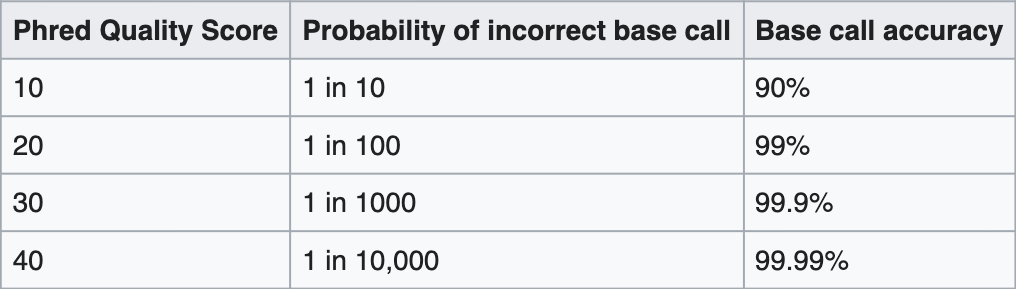</center>
<br>

**Fastq format**

Sequence data along with quality information are are stored in what is known as [fastq format](https://en.wikipedia.org/wiki/FASTQ_format). Each "read" is comprised of four lines in this format, so one read entry might look like this:


> ```
> @J00113:162:H7W32BBXX:1:1101:9658:1947 1:N:0:GGTGCG
> GTCAGTATCATGCTGCGGCTTCAAATCCGAAGTGATGTTTTGATGTGAAGTGAA
> +
> AAFFFJJJAAAAFAFFAFJAAAFJJJJJFFFJFFFJJFFJJJJJJJJJJJJJJJ
> ```

By definition, in this format:

1. the first line must begin with an '@' character followed by a unique identifier (this identifier may include information about the sequencing run such as the sequencing platform, run number, flow cell ID, and other information)

2. the second line is the sequence

3. the third line must start with a '+' character, and could hold additional information, but usually doesn't

4. the fourth and last line of an entry holds the quality scores corresponding to each base of the sequence in line 2, with quality numbers encoded as single characters (e.g., as described [here](http://drive5.com/usearch/manual/quality_score.html))

The FastQC program will evaluate the information provided for each read in the fastq files and generate a summary report about the quality of the sequence data. Assessing the raw sequence quality is important for determining if and how the reads need to be trimmed.

Here is how we can run it on our raw reads:

In [40]:
fastqc -t 6 -q -o fastqc-outputs raw-reads/*.gz 

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `fastqc`   - the primary command we're using
    - `-t`   - where we can specify how many we want to process at a time in parallel
    - `-q`   - telling the program not to print out everything it's doing (just because it's a little messy when running in parallel)
    - `-o`   - the directory where we want to put the output files
    - `raw-reads/*.gz` - this is providing all read files as a *positional* arugment (like we covered in the Unix Intro JN), the `*` is a wildcard that here means get anything in that directory that ends with `.gz`

</div>

In [41]:
ls fastqc-outputs

F10_R1_raw_fastqc.html	F8_R2_raw_fastqc.html	G5_R1_raw_fastqc.html
F10_R1_raw_fastqc.zip	F8_R2_raw_fastqc.zip	G5_R1_raw_fastqc.zip
F10_R2_raw_fastqc.html	F9_R1_raw_fastqc.html	G5_R2_raw_fastqc.html
F10_R2_raw_fastqc.zip	F9_R1_raw_fastqc.zip	G5_R2_raw_fastqc.zip
F3_R1_raw_fastqc.html	F9_R2_raw_fastqc.html	G8_R1_raw_fastqc.html
F3_R1_raw_fastqc.zip	F9_R2_raw_fastqc.zip	G8_R1_raw_fastqc.zip
F3_R2_raw_fastqc.html	G10_R1_raw_fastqc.html	G8_R2_raw_fastqc.html
F3_R2_raw_fastqc.zip	G10_R1_raw_fastqc.zip	G8_R2_raw_fastqc.zip
F5_R1_raw_fastqc.html	G10_R2_raw_fastqc.html	G9_R1_raw_fastqc.html
F5_R1_raw_fastqc.zip	G10_R2_raw_fastqc.zip	G9_R1_raw_fastqc.zip
F5_R2_raw_fastqc.html	G3_R1_raw_fastqc.html	G9_R2_raw_fastqc.html
F5_R2_raw_fastqc.zip	G3_R1_raw_fastqc.zip	G9_R2_raw_fastqc.zip
F8_R1_raw_fastqc.html	G3_R2_raw_fastqc.html
F8_R1_raw_fastqc.zip	G3_R2_raw_fastqc.zip


This program produces a zipped directory holding data, and a summary html file for each fastq file we gave it. We can look at one of these by navigating to it on the left and double-clicking on the html file, or just by [**clicking here for sample F10_R1**](../GL4U-amplicon-tutorial/fastqc-outputs/F10_R1_raw_fastqc.html) (so long as we haven't deleted it yet).

<div class="alert alert-block alert-info">
<b>NOTE</b><br>

There are many modules included in the `fastqc` program, with the documentation for each linked on [this page](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/). These are summarized in a pass (green check), warning (yellow exclamation point), and fail (red X) fashion. 
    
**It is important to note that although these modules are summarized in a pass/fail fashion, those indicators are based on expecting the data are completely random and diverse, which is often not the case depending on the type of sequencing that was done.** 
    
You can imagine if we were sequencing many copies of one gene type, this would not be random and diverse, and a lot of these modules may "fail". Therefore, it's not necessarily a problem if something doens't have a green check, this just provides an overview of our data from many angles. Sometimes the common causes for a particular module to fail or have a warning are noted in the [documentation pages](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/). 
</div>

Rather than looking through all of the fastqc reports individually, we can take advantage of [MultiQC](https://multiqc.info/) to combine them for us:

In [43]:
multiqc -o fastqc-outputs -n raw_multiqc fastqc-outputs


  /// ]8;id=3006;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.12

|           multiqc | MultiQC Version v1.14 now available!
|           multiqc | Search path : /Users/mdlee4/GL4U-amplicon-tutorial/fastqc-outputs
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 40/40  fastqc-outputs/F9_R2_raw_fastqc.htmlfastqc.html
|            fastqc | Found 20 reports
|           multiqc | Compressing plot data
|           multiqc | Report      : fastqc-outputs/raw_multiqc.html
|           multiqc | Data        : fastqc-outputs/raw_multiqc_data
|           multiqc | MultiQC complete


<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `multiqc`   - the primary command we're using
    - `-o`   - the directory where we want to put the output files
    - `-n`   - specifies the prefix name for the output files
    - `fastqc-outputs` - the directory holding the raw FastQC data from each sample, provided as a positional argument

</div>

Now let's remove all the individual fastqc files using our `*` wildcard again:

In [44]:
rm fastqc-outputs/*fastqc*
ls fastqc-outputs

raw_multiqc.html  raw_multiqc_data


Multiqc produces a data directory and also a summary html file. We can open and look at the multiqc summary with the file browser on the left, or by [**clicking here**](../GL4U-amplicon-tutorial/fastqc-outputs/raw_multiqc.html). Be sure to click "Trust HTML" at the top-left after opening.

**Take a look at the multiQC report of the raw fastQC data and answer the following questions:**

1. Which sample was sequenced at the greatest read depth? The least read depth? (Hint: Click on the "Number of reads" button in the "Sequence Counts" section.)

2. What do you notice about the quality of the raw sequence data (from the "Sequence Quality Histograms" module)? Are there any differences between the forward and reverse reads?

3. Were adapters detected?

4. Should we be worried about any of the modules that "failed"?

5. Should we trim and/or filter the data? Why or why not?

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

Sample G5 has the most reads at about 32,000. And Sample G9 has the fewest at about 25,000.
    
</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The quality scores stay above 35 for pretty much the entire reads. The little dip at the start is common (likely because of low sequence diversity at the start, lowering the confidence of the base calls there). 
    
Here there is no real difference between the forward and reverse reads, which is pretty atypical. Normally the reverse reads have slightly slower quality towards their ends than do the forward reads.
    
</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

No, these would be listed in the "Adapter Content" module.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q4 Solution</b></summary>

<br>

No, we don't need to worry about them. Failed ones here include "Per Base Sequence Content", "Per Sequence GC Content", "Sequence Duplication Levels", and "Overrepresented Sequences". For the type of sequencing done here, where we are making many copies of one portion of one gene, these are all expected to "fail", as our sequencing is intentionally not resulting in a random and diverse library of sequences. 

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q5 Solution</b></summary>

<br>

While these data look pretty great overall, it is still a good idea to trim/filter them. One arguable reason to do so is that these quality plots only show the averages, so there may be some reads with poor quality we might still want to filter out. And there can be other reasons to want to filter/trim still, but there wouldn't be many reasons to *not* do it.

</details>
</div>

---

**For now, we are going to move onto our [amplicon processing notebook](05-amplicon-processing.ipynb), but we will return here after we filter our reads in order to use FastQC/MultiQC again.**

---

<a class="anchor" id="filteredqa"></a>

## 3. Quality assessment of filtered reads

After we've generated our trimmed and filtered reads in the amplicon processing notebook, we can move forward here to assess their quality using fastqc and multiqc.

First let's check that our filtered read files are present where we expect them to be:

In [46]:
ls trimmed-and-filtered-reads

F10_R1_filtered.fastq.gz  F8_R2_filtered.fastq.gz   G5_R1_filtered.fastq.gz
F10_R2_filtered.fastq.gz  F9_R1_filtered.fastq.gz   G5_R2_filtered.fastq.gz
F3_R1_filtered.fastq.gz   F9_R2_filtered.fastq.gz   G8_R1_filtered.fastq.gz
F3_R2_filtered.fastq.gz   G10_R1_filtered.fastq.gz  G8_R2_filtered.fastq.gz
F5_R1_filtered.fastq.gz   G10_R2_filtered.fastq.gz  G9_R1_filtered.fastq.gz
F5_R2_filtered.fastq.gz   G3_R1_filtered.fastq.gz   G9_R2_filtered.fastq.gz
F8_R1_filtered.fastq.gz   G3_R2_filtered.fastq.gz


Now we'll run fastqc and multiqc the same way we did above, except we'll point to the files in the trimmed-and-filtered-reads directory:

In [47]:
fastqc -t 6 -q -o fastqc-outputs trimmed-and-filtered-reads/*.gz 

In [48]:
multiqc -o fastqc-outputs -n filtered_multiqc fastqc-outputs


  /// ]8;id=415693;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.12

|           multiqc | MultiQC Version v1.14 now available!
|           multiqc | Search path : /Users/mdlee4/GL4U-amplicon-tutorial/fastqc-outputs
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 47/47  utputs/F9_R1_filtered_fastqc.htmlltered_fastqc.html
|            snippy | Found 1 reports
|          bargraph | Tried to make bar plot, but had no data: snippy_variants
|            fastqc | Found 20 reports
|           multiqc | Compressing plot data
|           multiqc | Report      : fastqc-outputs/filtered_multiqc.html
|           multiqc | Data        : fastqc-outputs/filtered_multiqc_data
|           multiqc | MultiQC complete


Again, we'll remove all individual fastqc files:

In [49]:
rm fastqc-outputs/*fastqc*

In [50]:
ls fastqc-outputs

filtered_multiqc.html  raw_multiqc.html
filtered_multiqc_data  raw_multiqc_data


Then like before, we can open and look at the multiqc summary with the file browser on the left, or by [**clicking here**](../GL4U-amplicon-tutorial/fastqc-outputs/filtered_multiqc.html). Be sure to click "Trust HTML" at the top-left after opening.

**Take a look at the multiQC report of the trimmed and filtered fastQC data above and answer the following questions:**

1. How many reads are there in the G5 sample after trimming? What about the G9 sample? Are they still the samples sequenced at the greatest and least read depth, respectively? (Hint: Click on the "Number of reads" button in the "Sequence Counts" section.)

2. What is the sequencing depth range among samples? Do you think this is an issue? 

3. What do you notice about the quality of the trimmed sequence data compared with the raw (looking at the "Sequence Quality Histograms" module)?

4. Do you think we're ready to move forward with this filtered data? Why or why not?


<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

G5 has just over 28,000 reads (down from about 32,000), and G9 has just over 22,000 (down from about 25,000). 
    
Yes, they are still the 2 samples with the greatest and fewest reads.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The range is about 22,000 reads to 28,000. This is not an issue, though whether we decide something is an issue or not is subjective, and it is often based on what these data typically look like. So it is hard to say when you're not yet used to looking at these types of summary metrics.


</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

While the starting data quality was already pretty good, it is even more consistent now and there is no dip in quality in the front. 

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q4 Solution</b></summary>

<br>

Yes, they have high quality profiles, no adapter content detected, and the primers have been removed.

</details>
</div>


<br>

---

**Now let's head back to the [amplicon processing notebook](05-amplicon-processing.ipynb#Generate-error-model-of-data), where we are ready to proceed with generating an error profile of our data.**


---
---

[**Previous:** 3. R intro](03-R-intro.ipynb)
<br>

<div style="text-align: right"><a href="05-amplicon-processing.ipynb"><b>Next:</b> 5. Amplicon processing</a></div>

